<a href="https://colab.research.google.com/github/egyvedriyanto78/Forecasting-Experiment/blob/main/GoldOnlyExpGRU001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Experiment with Gold Closing Price Only using GRU

## Data Collection

In [1]:
# Install yfinance package jika belum diinstall
!pip install yfinance

In [3]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Library untuk GRU
import tensorflow as tf
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Fetch data GOLD (XAU/USD) dari Yahoo Finance
import yfinance as yf

In [4]:
# Definisikan rentang waktu data
start_date = "2013-05-03"
end_date = "2022-12-31"

# Ambil data GOLD (harga emas) dari Yahoo Finance
gold_data = yf.download("GC=F", start=start_date, end=end_date)[['Close']].rename(columns={'Close': 'GOLD'})

# Ubah index ke kolom tanggal
gold_data.index = pd.to_datetime(gold_data.index)
gold_data = gold_data.reset_index()
gold_data.columns = ['Date', 'GOLD']

# Hapus informasi timezone pada tanggal
gold_data['Date'] = gold_data['Date'].dt.tz_localize(None)

# Tampilkan data GOLD
print(gold_data.head())

[*********************100%***********************]  1 of 1 completed

        Date         GOLD
0 2013-05-03  1464.300049
1 2013-05-06  1468.099976
2 2013-05-07  1449.000000
3 2013-05-08  1473.900024
4 2013-05-09  1468.800049


## Data Visualization

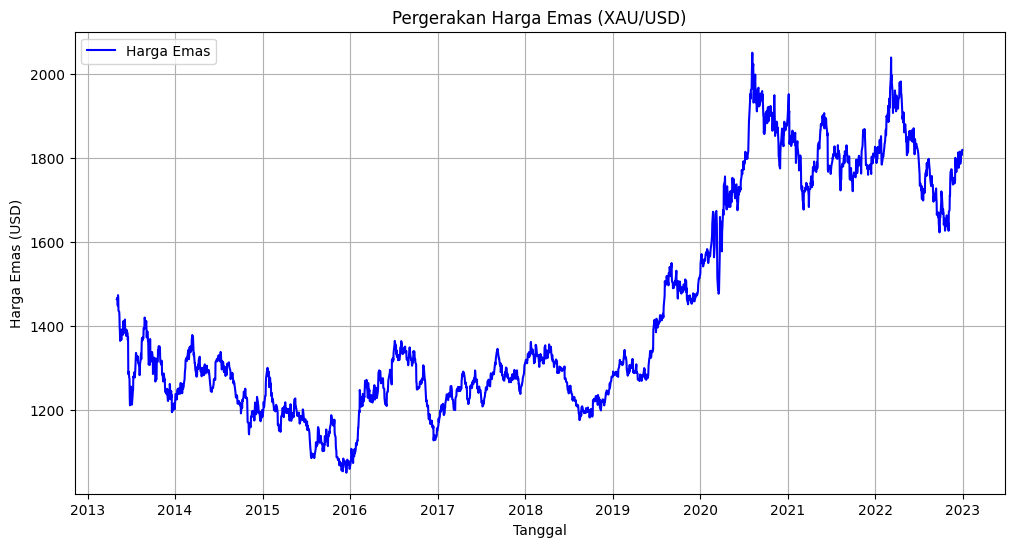

In [5]:
# Plot harga emas dari awal hingga akhir
plt.figure(figsize=(12, 6))
plt.plot(gold_data['Date'], gold_data['GOLD'], color='blue', label='Harga Emas')
plt.title('Pergerakan Harga Emas (XAU/USD)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()

## Data Preprocessing

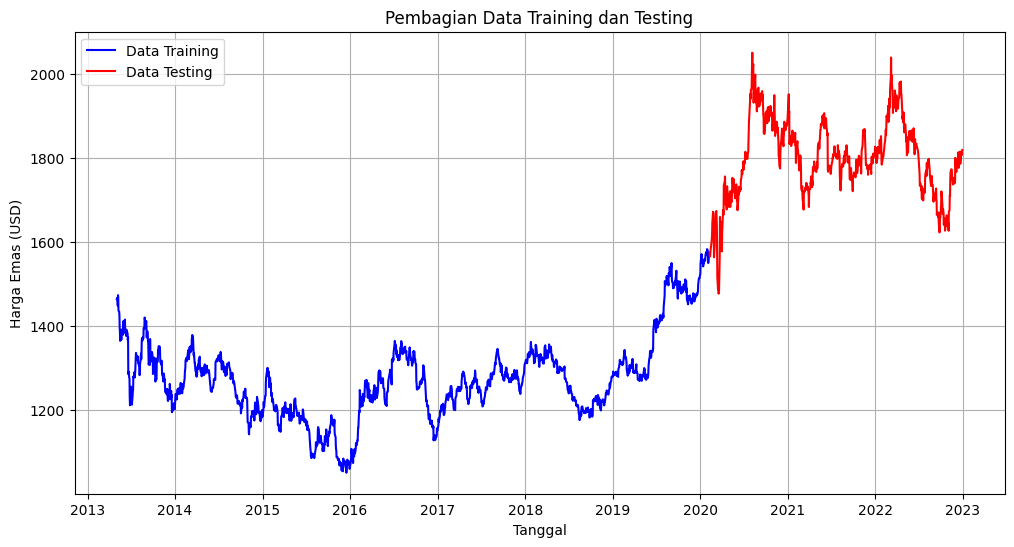

In [6]:
# Normalisasi data agar LSTM dapat belajar lebih baik
scaler = MinMaxScaler(feature_range=(0, 1))
gold_data['Scaled'] = scaler.fit_transform(gold_data[['GOLD']])

# Splitting manual: 70% untuk training, 30% untuk testing
train_size = int(len(gold_data) * 0.7)
train_data = gold_data[:train_size]
test_data = gold_data[train_size:]

# Visualisasi data train dan test
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['GOLD'], color='blue', label='Data Training')
plt.plot(test_data['Date'], test_data['GOLD'], color='red', label='Data Testing')
plt.title('Pembagian Data Training dan Testing')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()

In [7]:
# Fungsi untuk membentuk data ke format GRU
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Gunakan kolom 'Scaled' untuk pelatihan
time_step = 60  # Menggunakan 60 hari terakhir untuk memprediksi
X_train, y_train = create_dataset(train_data[['Scaled']].values, time_step)
X_test, y_test = create_dataset(test_data[['Scaled']].values, time_step)

# Reshape ke [samples, time steps, features] untuk input GRU
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Modeling

In [8]:
# Inisialisasi model
model_gru = Sequential()

# Tambahkan layer GRU dan Dropout
model_gru.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(50, return_sequences=False))
model_gru.add(Dropout(0.2))

# Layer output
model_gru.add(Dense(1))

# Kompilasi model
model_gru.compile(optimizer='adam', loss='mean_squared_error')

# Ringkasan model
model_gru.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,301 (91.02 KB)

 Trainable params: 23,301 (91.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0122 - val_loss: 0.0030
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 9.9476e-04 - val_loss: 7.2505e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 8.3841e-04 - val_loss: 9.4755e-04
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 8.7341e-04 - val_loss: 0.0013
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 6.9916e-04 - val_loss: 6.1259e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 6.0011e-04 - val_loss: 8.1028e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.1475e-04 - val_loss: 5.7456e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 6.0167e-04 - val_loss: 9.6323e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 5.7649e-04 - val_loss: 0.0015
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 6.0968e-04 - val_loss: 5.9953e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 5.6326e-04 - val_loss: 5.

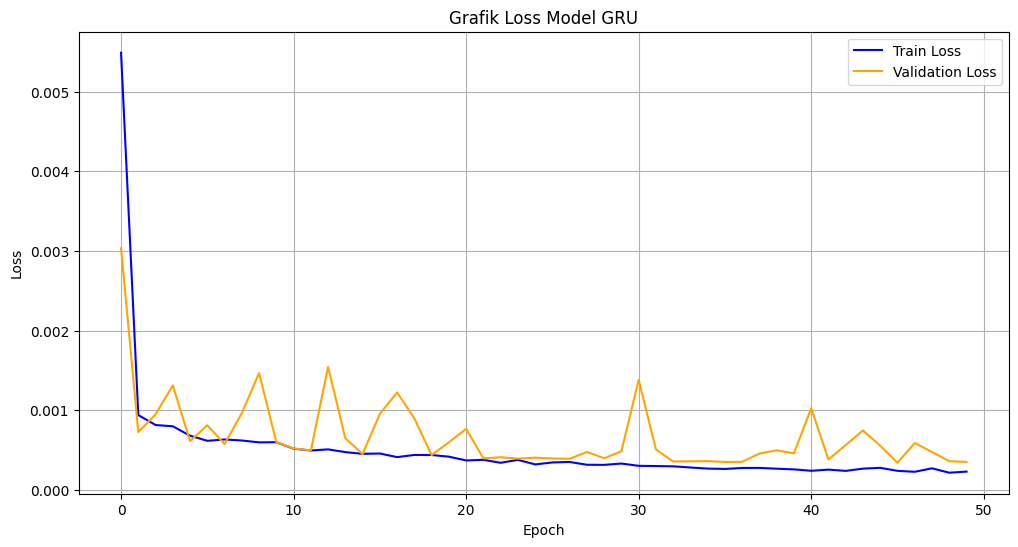

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 2.5509e-04 - val_loss: 7.2445e-04
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 2.3165e-04 - val_loss: 8.0470e-04
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.6143e-04 - val_loss: 4.7099e-04
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 2.3132e-04 - val_loss: 7.0056e-04
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 2.3141e-04 - val_loss: 7.5705e-04
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 2.3368e-04 - val_loss: 3.9592e-04
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 2.7227e-04 - val_loss: 3.6968e-04
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 2.3072e-04 - val_loss: 5.9245e-04
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 2.2389e-04 - val_loss: 3.7995e-04
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 2.3377e-04 - val_loss: 3.4628e-04
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 2.2539e-0

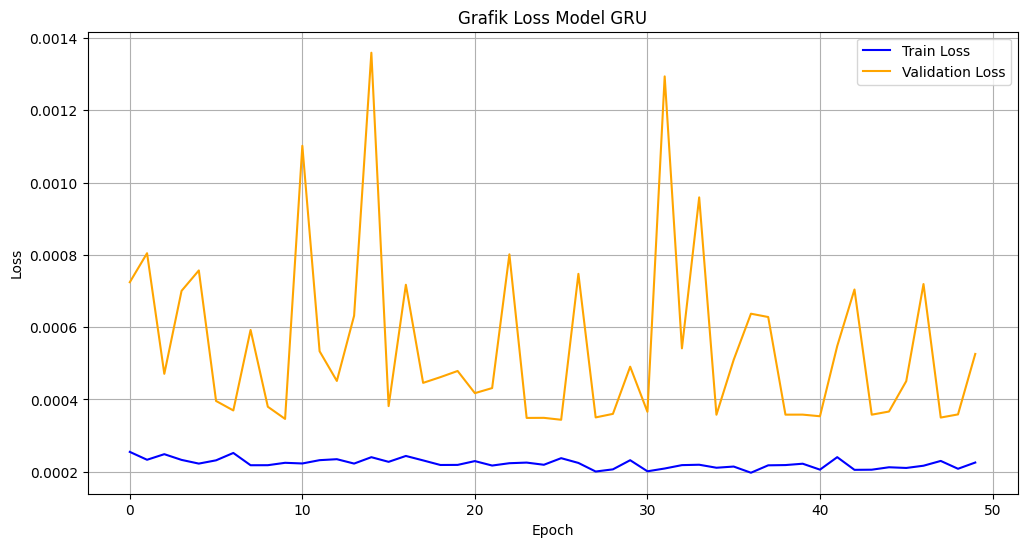

In [9]:
# Melatih model GRU
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Menampilkan plot loss untuk memantau training
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Train Loss', color='blue')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Grafik Loss Model GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
# Melatih model GRU
history_gru = model_gru.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# Menampilkan plot loss untuk memantau training
plt.figure(figsize=(12, 6))
plt.plot(history_gru.history['loss'], label='Train Loss', color='blue')
plt.plot(history_gru.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Grafik Loss Model GRU')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Model Evaluation

In [13]:
# Evaluasi pada data training dan testing
train_predict_gru = model_gru.predict(X_train)
test_predict_gru = model_gru.predict(X_test)

# Mengembalikan data ke skala asli
train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Hitung metrik evaluasi
train_rmse_gru = np.sqrt(mean_squared_error(y_train_actual, train_predict_gru))
test_rmse_gru = np.sqrt(mean_squared_error(y_test_actual, test_predict_gru))
train_mae_gru = mean_absolute_error(y_train_actual, train_predict_gru)
test_mae_gru = mean_absolute_error(y_test_actual, test_predict_gru)

# Akurasi (MAPE)
train_mape_gru = np.mean(np.abs((y_train_actual - train_predict_gru) / y_train_actual)) * 100
test_mape_gru = np.mean(np.abs((y_test_actual - test_predict_gru) / y_test_actual)) * 100

# Tampilkan hasil evaluasi
eval_results_gru = pd.DataFrame({
    "Dataset": ["Training", "Testing"],
    "RMSE": [train_rmse_gru, test_rmse_gru],
    "MAE": [train_mae_gru, test_mae_gru],
    "MAPE": [train_mape_gru, test_mape_gru]
})

print(eval_results_gru)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Dataset       RMSE        MAE      MAPE
0  Training  11.827654   8.788735  0.686177
1   Testing  22.951438  18.701469  1.026288


## Model Prediction

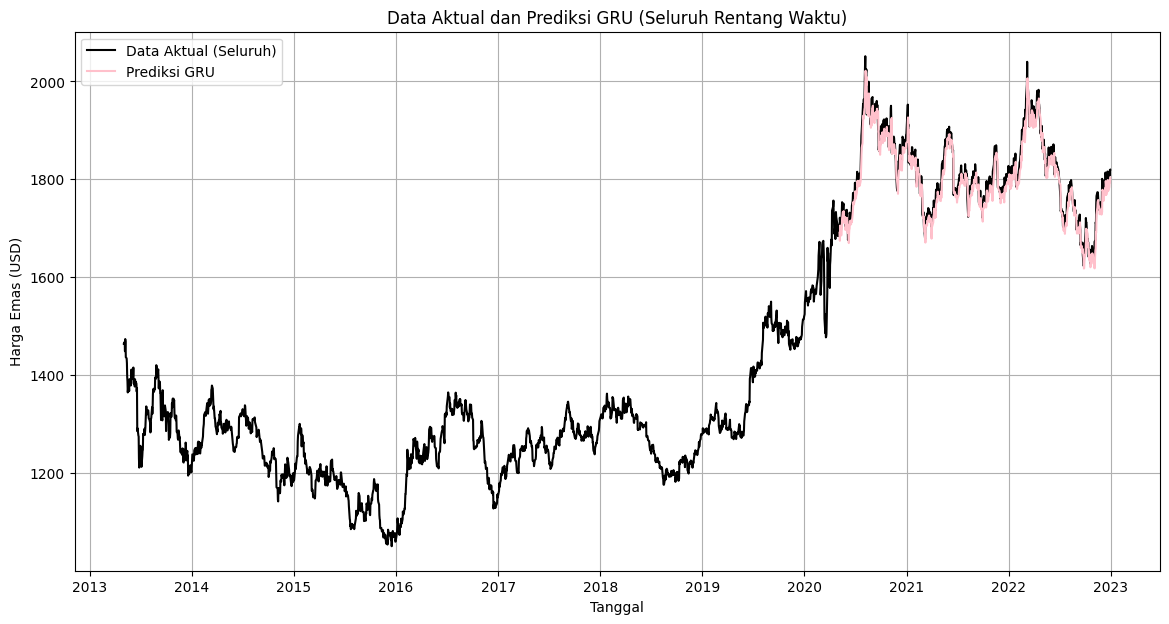

In [16]:
# Gabungkan data aktual dan prediksi untuk seluruh rentang waktu
full_data_gru = gold_data.copy()
full_data_gru['Predicted'] = np.nan

# Isi prediksi hanya untuk 30% terakhir
full_data_gru.loc[len(full_data_gru) - len(test_predict_gru):, 'Predicted'] = test_predict_gru.flatten()

# Plot seluruh data dengan prediksi
plt.figure(figsize=(14, 7))
plt.plot(full_data_gru['Date'], full_data_gru['GOLD'], label='Data Aktual (Seluruh)', color='black')
plt.plot(full_data_gru['Date'], full_data_gru['Predicted'], label='Prediksi GRU', color='pink')

plt.title('Data Aktual dan Prediksi GRU (Seluruh Rentang Waktu)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()

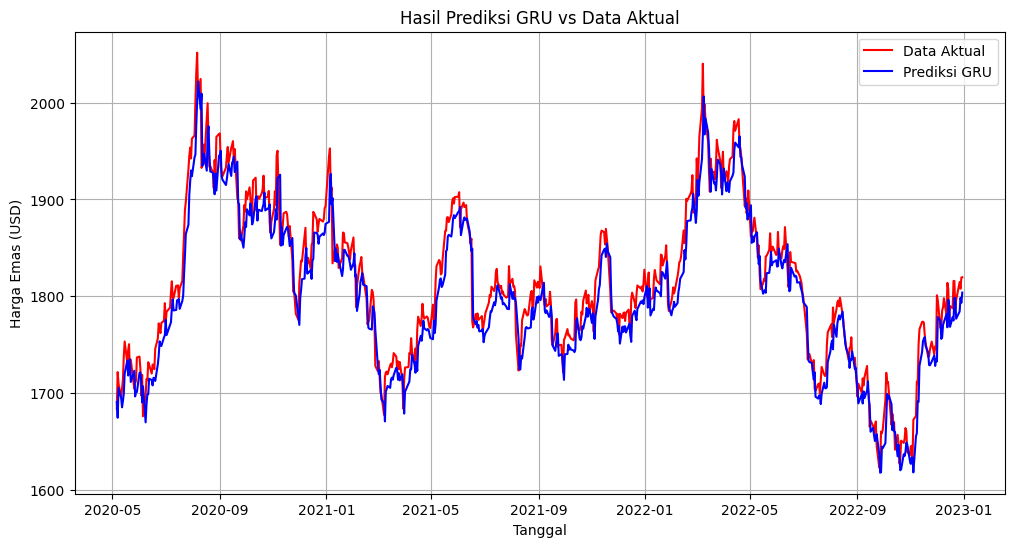

In [14]:
# Visualisasi hasil prediksi
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'][time_step:], y_test_actual, color='red', label='Data Aktual')
plt.plot(test_data['Date'][time_step:], test_predict_gru, color='blue', label='Prediksi GRU')
plt.title('Hasil Prediksi GRU vs Data Aktual')
plt.xlabel('Tanggal')
plt.ylabel('Harga Emas (USD)')
plt.legend()
plt.grid()
plt.show()